In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
from PIL import Image
import sys
sys.path.append("../model")
sys.path.append("../tools")
sys.path.append("../attack")
from MLP_classifier import MultiClassClassifier
import torch
import open_clip
from utils import plot_tensor
from dataset import TaskAWithLabel
from attack import projected_gradient_descent
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [3]:
?projected_gradient_descent

Signature:
projected_gradient_descent(
    model_fn,
    x,
    eps,
    eps_iter,
    nb_iter,
    norm,
    clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    rand_init=True,
    rand_minmax=None,
    sanity_checks=True,
)
Docstring:
This class implements either the Basic Iterative Method
(Kurakin et al. 2016) when rand_init is set to False. or the
Madry et al. (2017) method if rand_init is set to True.
Paper link (Kurakin et al. 2016): https://arxiv.org/pdf/1607.02533.pdf
Paper link (Madry et al. 2017): https://arxiv.org/pdf/1706.06083.pdf
:param model_fn: a callable that takes an input tensor and returns the model logits.
:param x: input tensor.
:param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
:param eps_iter: step size for each attack iteration
:param nb_iter: Number of attack iterations.
:param norm: Order of the norm (mimics NumPy). Possible values: np.inf, 1 or 2.
:param clip_min: (optional) float. Minimum float value for 

In [4]:
device = "cpu"
model = MultiClassClassifier(n_classes=2)
model.load_state_dict(torch.load("../model/checkpoints/binary_train_real2k_fake1999.pt",map_location=device))

clip, _, preprocess = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K',device=device)
clip.eval()
model.eval()

MultiClassClassifier(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (act): ReLU()
)

In [18]:
data  = TaskAWithLabel(path_to_csv="../../misc/scanFinal.csv",
                       path_to_taskA="/data4/saland/data/taskA.pt")

100%|██████████| 10080/10080 [00:04<00:00, 2053.66it/s]


true label: 0


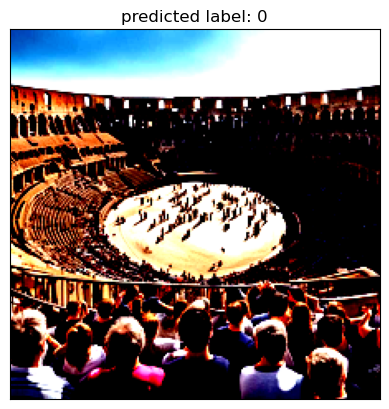

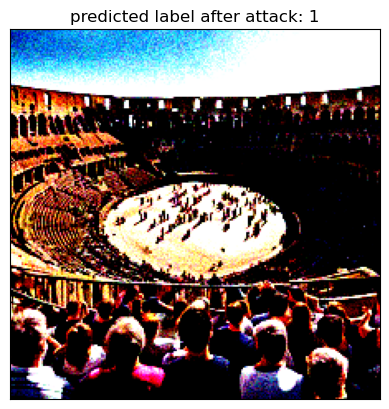

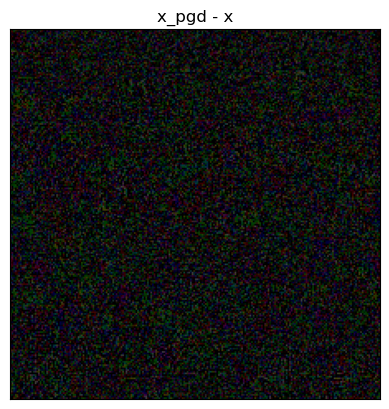

In [36]:
from matplotlib.image import warnings
def model_fn(x):
    features = clip.encode_image(x.unsqueeze(0))
    return model(features)

i = np.random.randint(0,len(data))
name = data.name[i]

true_label = data.label[i]
print("true label:",true_label.item())

x = preprocess(Image.open("/data3/TEST/A/" + name))

x_pred_label = torch.argmax(model_fn(x))
plot_tensor(np.clip(x,0,1),f"predicted label: {x_pred_label}")
plt.show()


eps = 0.25

x_pgd = projected_gradient_descent(model_fn,x,eps,0.01,40,np.inf).detach().requires_grad_(False)
x_pgd_pred_label = torch.argmax(model_fn(x_pgd))
plot_tensor(np.clip(x_pgd,0,1),f"predicted label after attack: {x_pgd_pred_label}")
plt.show()

diff = x_pgd - x

plot_tensor(np.clip(x_pgd - x,0,1),"x_pgd - x")
plt.show()